In [ ]:
# pip install Pillow

In [25]:
# Pandas and Numpy for data structures and util fucntions
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

import cnn_utils as utils
from model_evaluation_utils import get_metrics

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras import Model
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from PIL import Image
from tensorflow.python.keras.utils import np_utils

In [4]:
BATCH_SIZE = 64
EPOCHS = 5
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [5]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.15,
                                                  stratify=np.array(y_train),
                                                  random_state=42)

In [7]:
Y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
Y_val = np_utils.to_categorical(y_val, NUM_CLASSES)
Y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

In [8]:
print(X_train)

[[[[130 157 243]
   [125 153 239]
   [120 149 238]
   ...
   [114 144 230]
   [118 145 233]
   [118 144 233]]

  [[131 158 243]
   [126 155 241]
   [122 152 240]
   ...
   [109 140 227]
   [110 139 227]
   [108 137 225]]

  [[130 159 245]
   [121 152 239]
   [113 146 234]
   ...
   [103 135 225]
   [ 99 131 221]
   [ 95 128 218]]

  ...

  [[115  98 109]
   [111  94 104]
   [108  91 102]
   ...
   [131 115 126]
   [125 109 120]
   [113  97 108]]

  [[107  89 101]
   [107  90 101]
   [112  96 107]
   ...
   [124 108 119]
   [115  99 110]
   [109  94 105]]

  [[113  96 108]
   [120 104 115]
   [125 108 120]
   ...
   [116 101 111]
   [110  97 107]
   [113 100 110]]]


 [[[  7   5  73]
   [  1   5  71]
   [  3  14  86]
   ...
   [ 26  49  71]
   [ 18  42  47]
   [ 21  42  33]]

  [[  3   2  68]
   [  2  10  73]
   [  4  22  83]
   ...
   [ 22  35  79]
   [ 41  62  84]
   [ 44  71  64]]

  [[  1  10  65]
   [  3  20  74]
   [  2  25  78]
   ...
   [ 64  87 106]
   [ 78 107 111]
   [ 59  95

In [9]:
# # X_train = np.array([sp.misc.imresize(x,
# #                                      (48, 48)) for x in X_train])
# X_train= np.array([Image.fromarray(x).resize((48,48)) for x in X_train])

# # X_val = np.array([sp.misc.imresize(x,
# #                                    (48, 48)) for x in X_val])
# X_val = np.array([Image.fromarray(x).resize((48,48)) for x in X_val])
# # X_test = np.array([sp.misc.imresize(x,
# #                                     (48, 48)) for x in X_test])
# X_test = np.array([Image.fromarray(x).resize((48,48)) for x in X_test])

In [10]:
# print(X_train.shape)
# print(X_val.shape)
# print(X_test.shape)

In [11]:
# pip install scikit-image

In [12]:
from skimage import transform

In [13]:
# X_train = np.array([sp.misc.imresize(x,
#                                      (48, 48)) for x in X_train])
X_train= np.array([transform.resize(x, (48,48)) for x in X_train])

# X_val = np.array([sp.misc.imresize(x,
#                                    (48, 48)) for x in X_val])
X_val = np.array([transform.resize(x, (48,48)) for x in X_val])
# X_test = np.array([sp.misc.imresize(x,
#                                     (48, 48)) for x in X_test])
X_test = np.array([transform.resize(x, (48,48)) for x in X_test])

In [14]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(42500, 48, 48, 3)
(7500, 48, 48, 3)
(10000, 48, 48, 3)


In [15]:
base_model = vgg.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(48, 48, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [16]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [17]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

In [18]:
for layer in base_model.layers:
     layer.trainable = False

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [21]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [22]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train,
                                     batch_size=BATCH_SIZE)

In [23]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

In [24]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/5
664/664 [==============================] - 861s 1s/step - loss: 0.2444 - accuracy: 0.4450 - val_loss: 0.2489 - val_accuracy: 0.4053
Epoch 2/5
664/664 [==============================] - 838s 1s/step - loss: 0.1991 - accuracy: 0.5595 - val_loss: 0.1785 - val_accuracy: 0.6052
Epoch 3/5
664/664 [==============================] - 829s 1s/step - loss: 0.1852 - accuracy: 0.5974 - val_loss: 0.1713 - val_accuracy: 0.6265
Epoch 4/5
664/664 [==============================] - 870s 1s/step - loss: 0.1766 - accuracy: 0.6165 - val_loss: 0.1641 - val_accuracy: 0.6426
Epoch 5/5
664/664 [==============================] - 843s 1s/step - loss: 0.1709 - accuracy: 0.6328 - val_loss: 0.1609 - val_accuracy: 0.6509


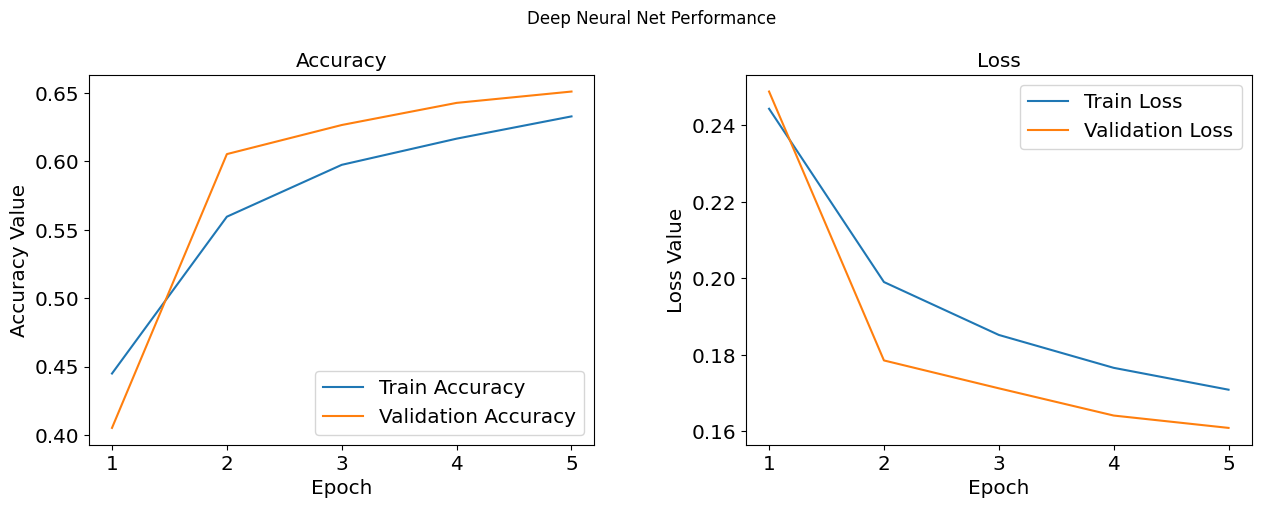

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [27]:
predictions = model.predict(X_test/255.)

313/313 [==============================] - 169s 538ms/step


In [28]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def get_metrics(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    return metrics

# Example usage:
true_labels = [1, 0, 1, 1, 0]
predicted_labels = [1, 1, 1, 0, 1]

metrics = get_metrics(true_labels, predicted_labels)
print(metrics)

{'Accuracy': 0.4, 'Precision': 0.5, 'Recall': 0.6666666666666666, 'F1 Score': 0.5714285714285715}


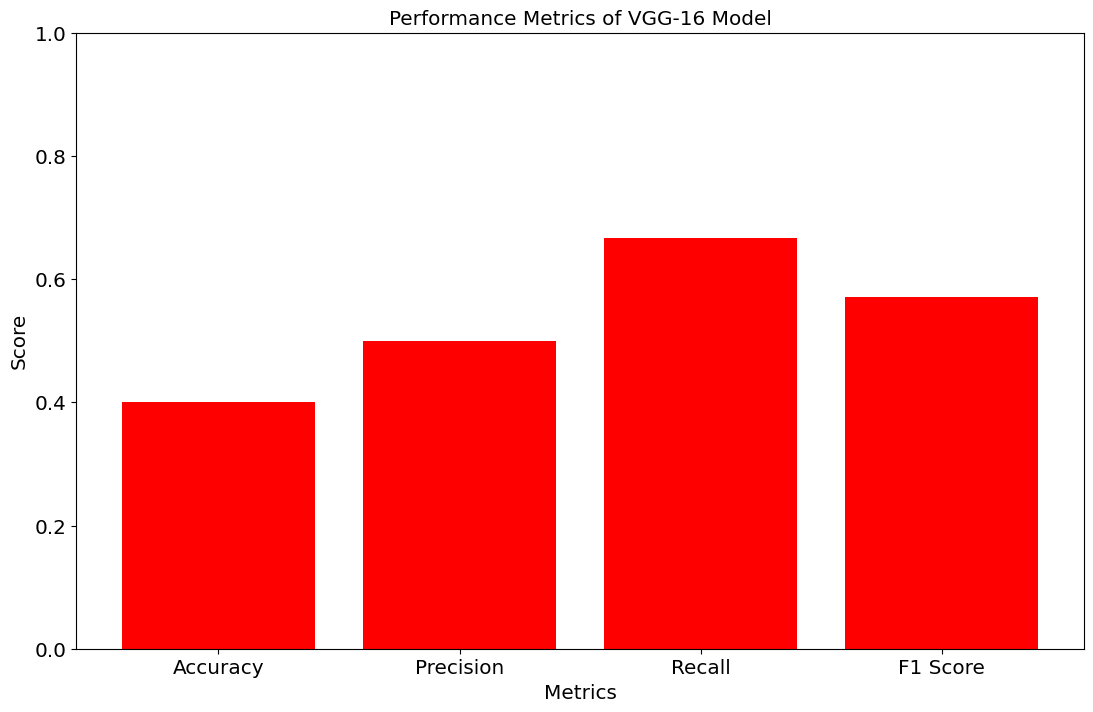

In [32]:
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Create bar plot
plt.figure(figsize=(13, 8))
plt.bar(metric_names, metric_values, color='red')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Metrics of VGG-16 Model')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.show()

In [31]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}